# Exercise 2
# Exploring the sensitivity of single-column sea ice model - Icepack

* **Description**: Starting point for exploring the sensitivity of Icepack to variations in the parameterizations and forcing values.
* **Creator**: David Clemens-Sewall
* **Date**: March 2025

## Background

When using models to make predictions of physical systems, we often want to be aware of the models' sensitivity to differences in internal and external conditions. Sensivity describes how much does the output of the model change due to the change in conditions. For example, consider trying to throw a ball to a partner. The parameters (internal conditions) of this model include the size and weight of the ball, your throwing mechanics, and how far away your target is. External conditions could include winds. And the output of this model is whether or not your partner catches the ball. Consider trying to make the throw in weak and strong winds. If you are throwing a light ball, such as a wiffle ball, then your likelihood of success is much lower in strong winds than in weak winds. However, if instead you were throwing a heavy ball, such as a lacrosse ball, then your likelihood of success is probably similar regardless of wind conditions. In this case, the sensivity of the model's output (whether or not the throw successfully reaches the target) to an external condition (wind speed) depends on the internal parameters (the type of the ball).

Sensitivity analyses with sea ice models can help us address two important questions:
 1. If something were to change in the future (e.g., the oceanic heat flux were to increase), how large of an impact could that have on the ice evolution?
 2. If there is an uncertainty in the model's parameterizations, how large of an impact could that have on the ice evolution?

### A note on sensitivity analyses for standalone sea ice models
Standalone sea ice models are a useful, and efficient tool for conducting sensitivity analyses of the Arctic system. But when interpreting their results, it is important to keep in mind that the sensitivities of the true system also depend on changes in the atmosphere and the ocean--which are not represented in a standalone sea ice model. Positive or negative feedbacks with the other parts of the system will amplify or reduce, respectively, the sensitivity seen in a standalone sea ice model.

## Example 1: Sensitivity to a forcing - Oceanic heat flux convergence

The oceanic heat flux convergence (namelist variable `qdp_fixed`) into the mixed layer depends on ocean dynamics, and can vary substantially in space and time. In the prior simulation, Icepack was run with the default value of 0 W m<sup>-2</sup>. In this example let us examine what happens if the oceanic heat flux convergence were 6 W m<sup>-2</sup>. Before running the simulation, hypothesize what you expect the impact to be.

### Steps to run the simulation
1) From the Icepack root directory, setup an Icepack case using the settings `ionetcdf,histcdf` and give it a name that is indicative of the change you are testing. E.g.: `./icepack.setup -m conda -e linux -c ~/icepack-dirs/cases/sikumiut_elson_qdp6 -s ionetcdf,histcdf`

2) Navigate to that case directory. Build Icepack with the `./icepack.build` command. You should see Icepack compile.

3) Make the following edits to the icepack_in file:
```
    use_leap_years = .true.
    year_init      = 2024
    istep0         = 6960
    npt            = 3792
    
    ustar_min       = 0.005
    qdp_fixed       = -10.0

	hmix_fixed      = 3.0
	atm_data_type   = 'MDF'
	ocn_data_type   = 'default'
	fyear_init		= 2024
	atm_data_file   = 'sikumiut_MDF_20241001_20250325.nc'
    ice_data_file   = 'unknown_ice_data_file'
    atm_data_format = 'nc'
	precalc_forc  = .true.
```
Note that this is exactly the same as the simulation in Exercise 1, except that we have added `qdp_fixed = -10.0` and `ustar_min = 0.05`. `qdq_fixed` is the rate of oceanic heat flux convergence in W m<sup>-2</sup>. In Icepack heat fluxes are defined as positive downwards (i.e., from the atmosphere to the ice) so this value is negative to drive a heat flux upward into the mixed layer. `ustar_min` is the friction velocity in m/s at the ice-ocean interface. This change is equivalent to setting a strong current beneath the ice.

To save typing you can simply copy the icepack_in file from the previous case (`cp ../sikumiut_elson_base/icepack_in ./`) and then make the changes.

4) Run Icepack with the command `./icepack.submit`. You should see ICEPACK COMPLETED SUCCESSFULLY

### Examine Icepack output with changed oceanic heat flux

In [17]:
# Load required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# icepacktools is a small library containing functions to make it easier
# to work with Icepack output
from icepacktools import load_icepack_hist, plot_handler

In [18]:
# Load Icepack output
ip_dirs_path = "/home/dcsewall/code/docker_icepack_interactive/icepack-dirs"
run_dict = {"sikumiut_elson_base": None,
            "sikumiut_elson_qdp6": None, # we are loading output from both runs
            }

hist_dict = {}
for key, value in run_dict.items():
    hist_dict[key] = load_icepack_hist(run_name=key, 
                                       icepack_dirs_path=ip_dirs_path, 
                                       hist_filename=value,
                                       snhf=True)
    hist_dict[key]['flwnet'] = hist_dict[key]['flw'] + hist_dict[key]['flwout']


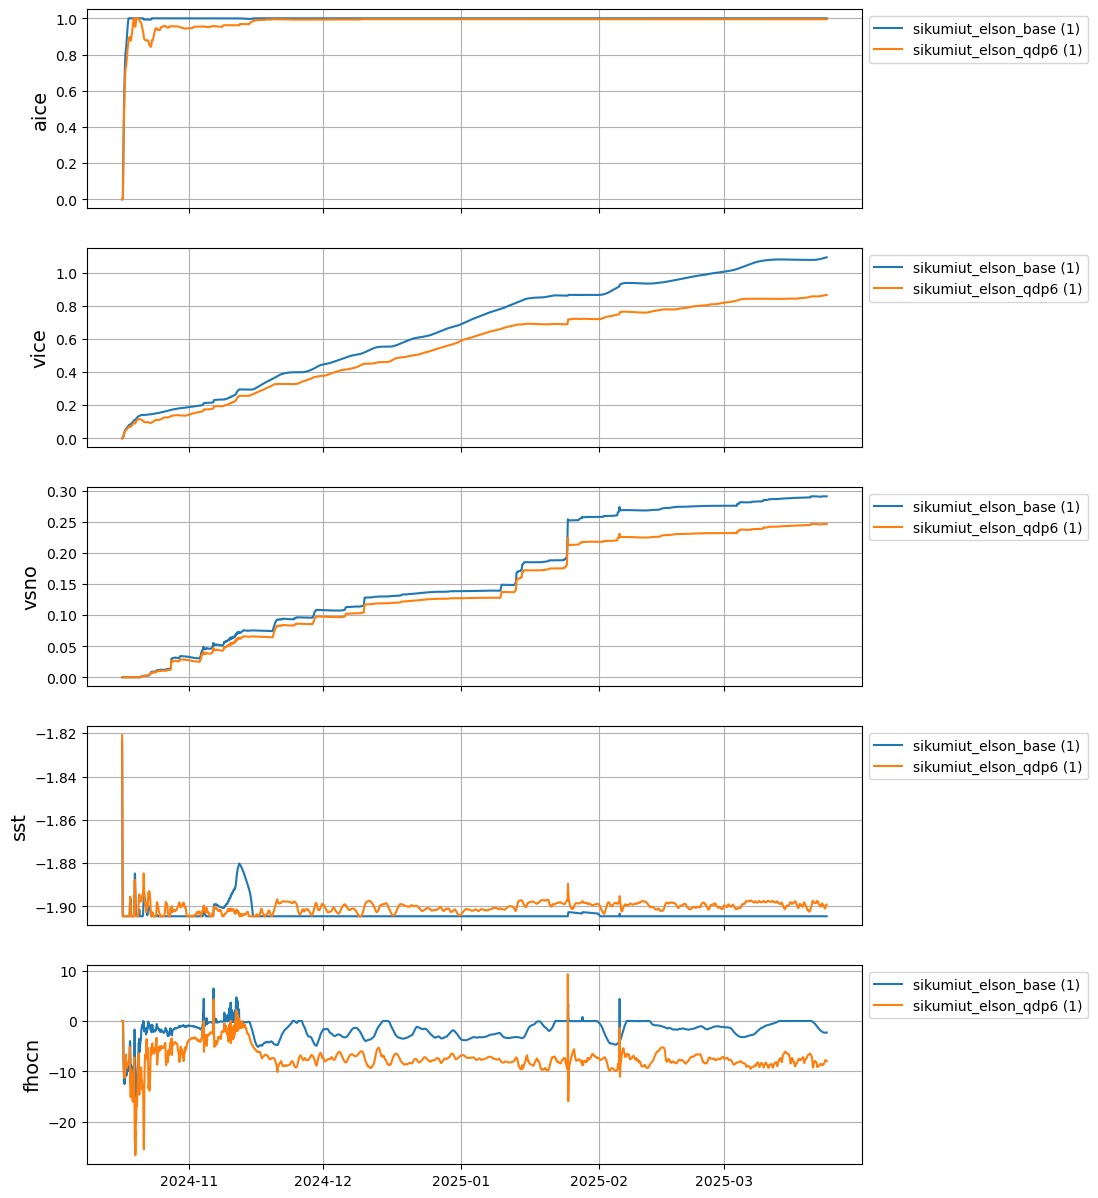

In [26]:
# Compare ice state evolution for different forcing

run_plot_dict = {"sikumiut_elson_base": [1],
                 "sikumiut_elson_qdp6": [1]}
# In addition to the ice state variables from before, let's also plot
# the mixed layer temperature (sst, degrees C) and the ice-ocean
# turbulent heat flux (fhocn, W/m2)
var_names = ['aice', 'vice', 'vsno', 'sst', 'fhocn']

f, axs = plot_handler(run_plot_dict, var_names, hist_dict)
plt.show()

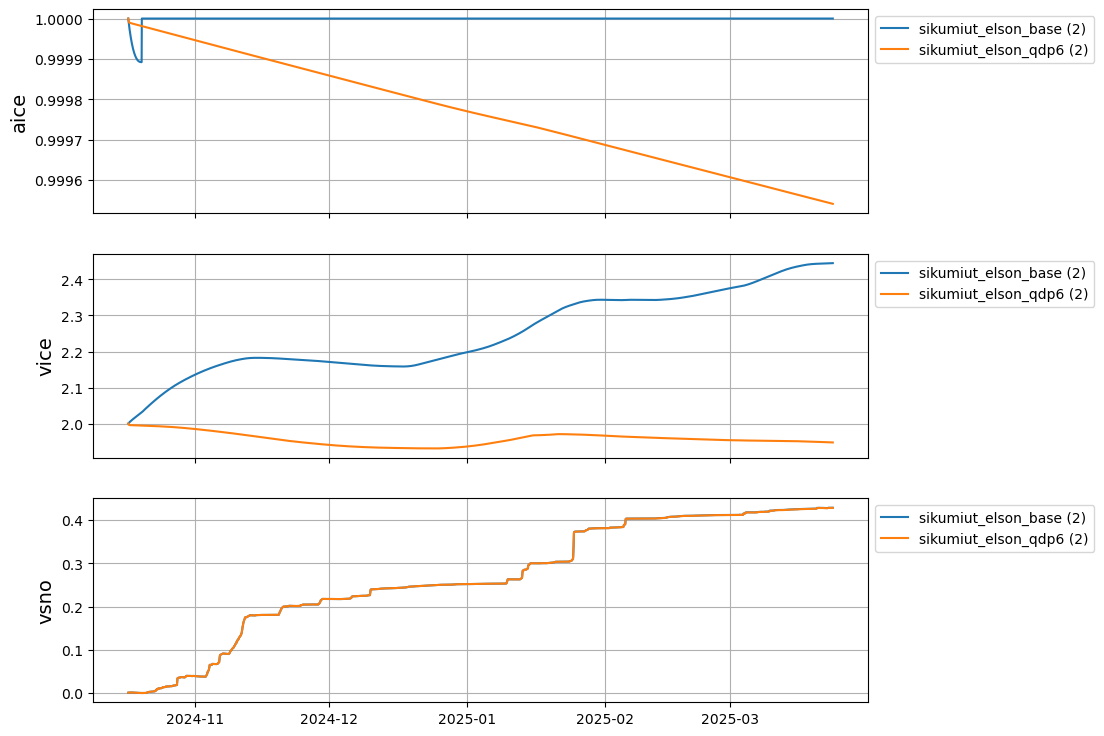

In [24]:
# Compare ice state evolution for different forcing

# Let's also examine what might have happened in the case that 
# the ice started 2 m thick (`ni = 2`)

run_plot_dict = {"sikumiut_elson_base": [2],
                 "sikumiut_elson_qdp6": [2]}
var_names = ['aice', 'vice', 'vsno']

f, axs = plot_handler(run_plot_dict, var_names, hist_dict)
plt.show()

#### Questions to consider

 + Did the change in oceanic heat flux have the impact you hypothesized? Why or why not?
 + Why was the simulated impact on ice thickness different for the ice grown from open water (`ni = 1`) vs. the ice that started 2 m thick (`ni = 2`)?

## Example 2: Sensitivity to a forcing - Snowfall rate

Precipitation (e.g., snowfall) measurements in the Arctic are notoriously difficult to make, and wind-driven snow redistribution can also change the amount of snow that accumulates on a specific sea ice floe. In this example, we consider how the ice might have evolved if half as much snow fell on it.

First we need to create a new forcing dataset with half the precipitation:

In [45]:
import xarray as xr

ds = xr.load_dataset('./data/sikumiut_MDF_20241001_20250325.nc')

# Divide the total precipitation rate (pr) and snowfall rate (prsn) by 2
ds['pr'].values = ds['pr'].values/2.0
ds['prsn'].values = ds['prsn'].values/2.0

ds.to_netcdf('./data/sikumiut_halfsno_MDF_20241001_20250325.nc')

# then, in the shell you need to run the following nco command
# `ncatted -O -a units,time60,a,c," 00:00:00" sikumiut_halfsno_MDF_20241001_20250325.nc`
# because how xarray writes attributes is subtley different from Icepacks's expectation

### Steps to run the simulation
1) Copy the file `sikumiut_halfsno_MDF_20241001_20250325.nc` from the sikumiut/icepack_activities/data into the MDF directory (~/icepack-dirs/input/Icepack_data/forcing/MDF).

2) From the Icepack root directory, setup an Icepack case using the settings `ionetcdf,histcdf` and give it a name that is indicative of the change you are testing. E.g.: `./icepack.setup -m conda -e linux -c ~/icepack-dirs/cases/sikumiut_elson_halfsno -s ionetcdf,histcdf`

3) Navigate to that case directory. Build Icepack with the `./icepack.build` command. You should see Icepack compile.

4) Make the following edits to the icepack_in file:
```
    use_leap_years = .true.
    year_init      = 2024
    istep0         = 6960
    npt            = 3792
    
    ustar_min       = 0.005
    qdp_fixed       = -10.0

	hmix_fixed      = 3.0
	atm_data_type   = 'MDF'
	ocn_data_type   = 'default'
	fyear_init		= 2024
	atm_data_file   = 'sikumiut_halfsno_MDF_20241001_20250325.nc'
    ice_data_file   = 'unknown_ice_data_file'
    atm_data_format = 'nc'
	precalc_forc  = .true.
```
Note that this is exactly the same as the simulation in Exercise 1, except that we have changed `atm_data_file   = 'sikumiut_halfsno_MDF_20241001_20250325.nc'`.

To save typing you can simply copy the icepack_in file from the previous case (`cp ../sikumiut_elson_base/icepack_in ./`) and then make the changes.

5) Run Icepack with the command `./icepack.submit`. You should see ICEPACK COMPLETED SUCCESSFULLY

In [46]:
# Load Icepack output
# we are just adding the new run to hist_dict
run_dict = {"sikumiut_elson_halfsno": None,
            }

for key, value in run_dict.items():
    hist_dict[key] = load_icepack_hist(run_name=key, 
                                       icepack_dirs_path=ip_dirs_path, 
                                       hist_filename=value,
                                       snhf=True)
    hist_dict[key]['flwnet'] = hist_dict[key]['flw'] + hist_dict[key]['flwout']


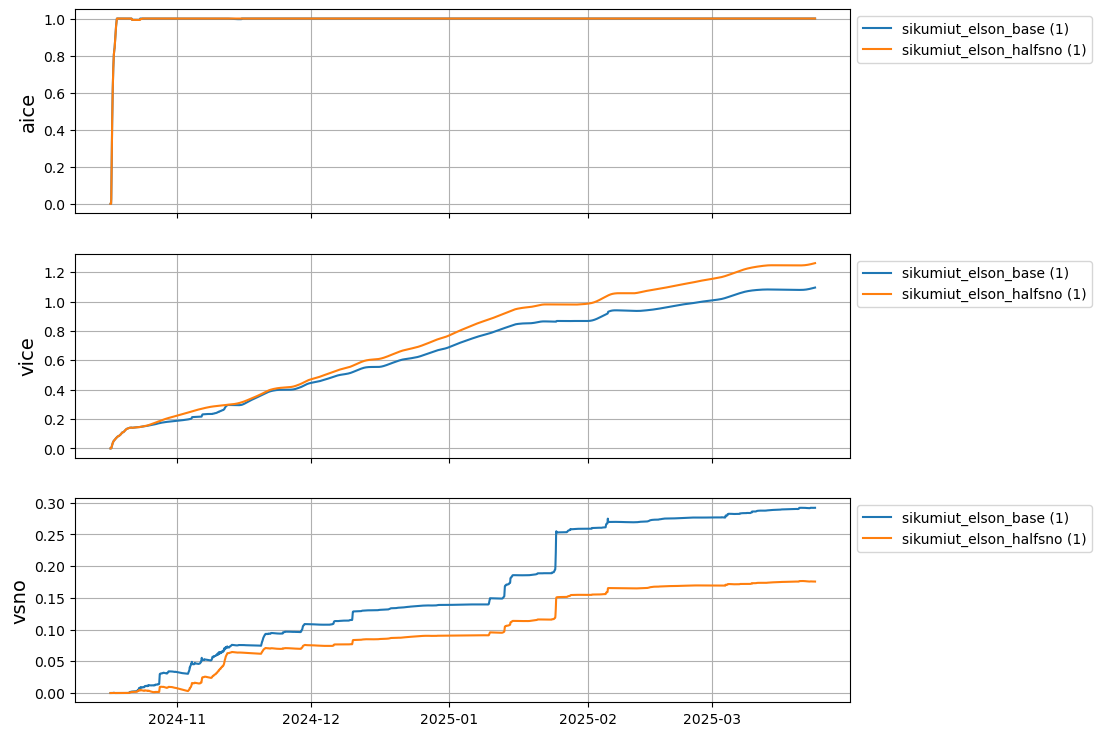

In [47]:
# Compare ice state evolution for different forcing

run_plot_dict = {"sikumiut_elson_base": [1],
                 "sikumiut_elson_halfsno": [1]}
var_names = ['aice', 'vice', 'vsno']

f, axs = plot_handler(run_plot_dict, var_names, hist_dict)
plt.show()

## Example 3: Sensitivity to a parameterization - congelation freezing

In the simulation in Exercise 1, you may have noticed that roughly 1/3 of the ice growth came from frazil ice formation. Did this surprise you? If you collected an ice core, did you see evidence of frazil ice throughout the core?

[Plante and others (2024)](https://doi.org/10.5194/tc-18-1685-2024) noticed a similar phenomenon in Icepack simulations of landfast ice in Labrador. They proposed a modification to how Icepack handles heat flux and ice growth at the ice-ocean interface. We can turn on this modification by setting `congel_freeze = 'one-step'` in the namelist. This is how new parameterizations are typically added to Icepack. They are provided as options that the user can choose to turn on or off via the namelist.

### Steps to run the simulation
1) From the Icepack root directory, setup an Icepack case using the settings `ionetcdf,histcdf` and give it a name that is indicative of the change you are testing. E.g.: `./icepack.setup -m conda -e linux -c ~/icepack-dirs/cases/sikumiut_elson_congel -s ionetcdf,histcdf`

2) Navigate to that case directory. Build Icepack with the `./icepack.build` command. You should see Icepack compile.

3) Make the following edits to the icepack_in file:
```
    use_leap_years = .true.
    year_init      = 2024
    istep0         = 6960
    npt            = 3792
    
    congel_freeze   = 'one-step'

	hmix_fixed      = 3.0
	atm_data_type   = 'MDF'
	ocn_data_type   = 'default'
	fyear_init		= 2024
	atm_data_file   = 'sikumiut_MDF_20241001_20250325.nc'
    ice_data_file   = 'unknown_ice_data_file'
    atm_data_format = 'nc'
	precalc_forc  = .true.
```
Note that this is exactly the same as the simulation in Exercise 1, except that we have added `congel_freeze = 'one-step'`.

To save typing you can simply copy the icepack_in file from the previous case (`cp ../sikumiut_elson_base/icepack_in ./`) and then make the change.

4) Run Icepack with the command `./icepack.submit`. You should see ICEPACK COMPLETED SUCCESSFULLY

In [28]:
# Load Icepack output
# we are just adding the new run to hist_dict
run_dict = {"sikumiut_elson_congel": None,
            }

for key, value in run_dict.items():
    hist_dict[key] = load_icepack_hist(run_name=key, 
                                       icepack_dirs_path=ip_dirs_path, 
                                       hist_filename=value,
                                       snhf=True)
    hist_dict[key]['flwnet'] = hist_dict[key]['flw'] + hist_dict[key]['flwout']


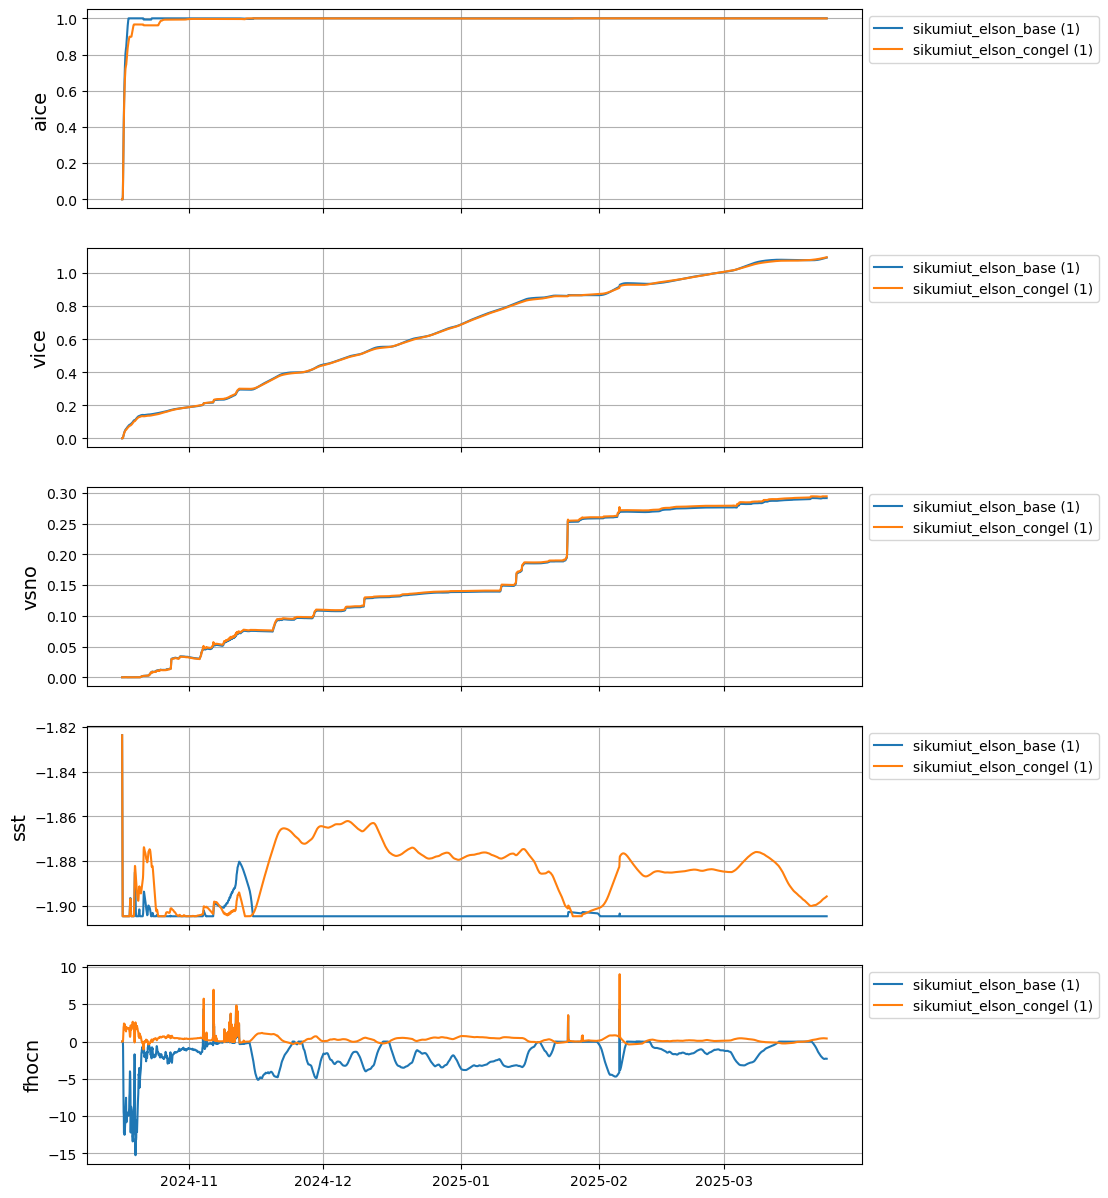

In [29]:
# Compare ice state evolution for different parameterization

run_plot_dict = {"sikumiut_elson_base": [1],
                 "sikumiut_elson_congel": [1]}
# In addition to the ice state variables from before, let's also plot
# the mixed layer temperature (sst, degrees C) and the ice-ocean
# turbulent heat flux (fhocn, W/m2)
var_names = ['aice', 'vice', 'vsno', 'sst', 'fhocn']

f, axs = plot_handler(run_plot_dict, var_names, hist_dict)
plt.show()

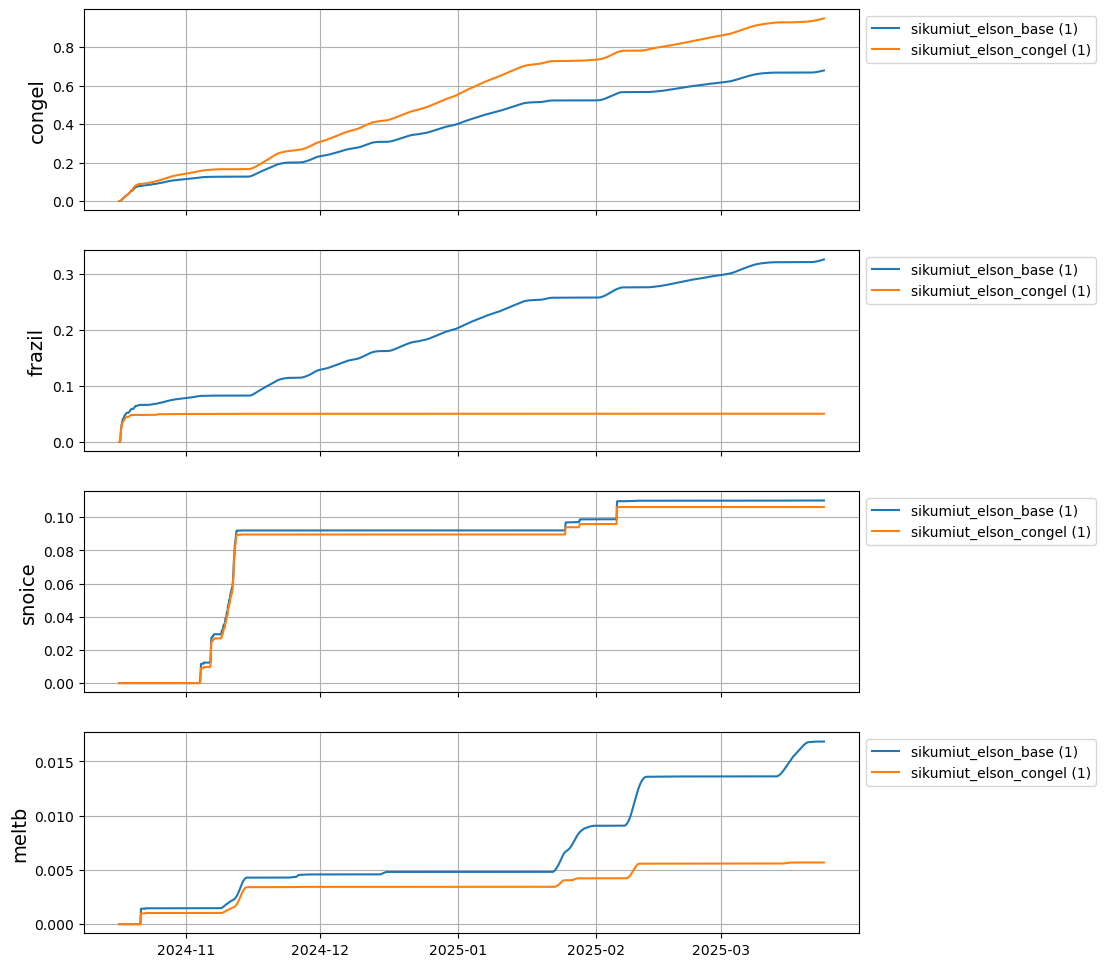

In [ ]:
# Plot cumulative ice mass balance variables

run_plot_dict = {"sikumiut_elson_base": [1],
                 "sikumiut_elson_congel": [1]}
# congel = congelation growth rate, frazil = frazil growth rate,
# snoice = snow-ice growth rate, meltb = basal ice melt rate
# the units of these rate terms are meters per model timestep
# so their cumulative sum is the same as the vice evolution above.
var_names = ['congel', 'frazil', 'snoice', 'meltb']


f, axs = plot_handler(run_plot_dict, var_names, hist_dict,
                      cumulative=True)
plt.show()

#### Questions to consider

 + How did changing the parameterization change the simulated ice evolution? Did it change the ice thickness? What about the mass balance terms?
 + If the parameterization doesn't change the ice thickness evolution in this case, why might it matter?
 + How might you design a field measurement campaign to assess which parameterization is more physically-plausible?

## Further exploration

What other sensitivities in the Icepack sea ice model are you interested in? Consider measurements that you have made (or could make) during Sikumiut. Us